# Generate fragment merges

Notebook shows how the fragment network is used to generate possible merges from a test set of 12 fragment pairs (identified from the Mpro dataset).
## Imports

In [1]:
from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem import AllChem, Draw
from neo4j import GraphDatabase
import matplotlib.pyplot as plt
import pandas as pd
import random
import pickle
import sys

# import scripts
sys.path.insert(1, '/home/sabsr3/xchem/fragment_network_merges/scripts')
from network import *  # will prompt for password to access database

## Load test set fragments

Test set fragments were manually identified from the Mpro dataset. Test set consists of a 'target' molecule (an existing merge), and two 'child' fragments, fragment A and fragment B. For the majority of the molecules, fragment B is a truncated version of the target molecule.

In [2]:
# load the test set csv
df = pd.read_csv('testset.csv')
df = df.drop(['Unnamed: 0'], axis=1)
df

,molecule,molecule_smiles,fraga,fraga_smiles,fragb,fragb_smiles
0,x0678,O=C(CC1CCCCC1)Nc1cccnc1,x0107,CC(=O)Nc1cnccc1C,x0678t,NC(=O)CC1CCCCC1
1,x2569,N#Cc1cncc(CC(=O)Nc2cccnc2)c1,x0305,CCNc1ccc(C#N)cn1,x2569t,NC(=O)Cc1cccnc1
2,x2572,Cc1ccncc1NC(=O)Cc1cccc(C#N)c1,x0107,CC(=O)Nc1cnccc1C,x2572t,N#Cc1cccc(CC(N)=O)c1
3,x2608,Cc1ccc(NC(=O)Nc2cccnc2)s1,x0434,O=C(Nc1ccccc1)Nc1cccnc1,x2608t,Cc1ccc(NC(N)=O)s1
4,x2643,O=C(Cc1ccc(Cl)s1)Nc1cccnc1,x0678,O=C(CC1CCCCC1)Nc1cccnc1,x2643t,NC(=O)Cc1ccc(Cl)s1
5,x2649,Cc1ccncc1NC(=O)C(C)c1cccc(Cl)c1,x0107,CC(=O)Nc1cnccc1C,x2649t,CC(C(N)=O)c1cccc(Cl)c1
6,x2908,Cc1ccncc1NC(=O)Nc1cccc(Cl)c1,x0107,CC(=O)Nc1cnccc1C,x2908t,NC(=O)Nc1cccc(Cl)c1
7,x2912,Cc1ccncc1NC(=O)C(C)c1cccc(C#N)c1,x0107,CC(=O)Nc1cnccc1C,x2912t,CC(C(N)=O)c1cccc(C#N)c1
8,x3080,Cc1ccncc1NC(=O)CN(C)S(=O)(=O)c1cccc2cccnc12,x0107,CC(=O)Nc1cnccc1C,x3080t,CN(CC(N)=O)S(=O)(=O)c1cccc2cccnc12
9,x2600,N#Cc1cccc(CC(=O)Nc2cccnc2)c1,x0678,O=C(CC1CCCCC1)Nc1cccnc1,x1249,N#Cc1ccc(CNC(=O)N2CCOCC2)cc1


In [3]:
# get smiles of fragments and convert to rdkit mols
target_smiles = list(df['molecule_smiles'])
target_mols = mols_from_smiles(target_smiles)
target_ids = [str(i) for i in df['molecule']]

fraga_smiles = list(df['fraga_smiles'])
fraga_mols = mols_from_smiles(fraga_smiles)
fraga_ids = [str(i) for i in df['fraga']]

fragb_smiles = list(df['fragb_smiles'])
fragb_mols = mols_from_smiles(fragb_smiles)
fragb_ids = [str(i) for i in df['fragb']]

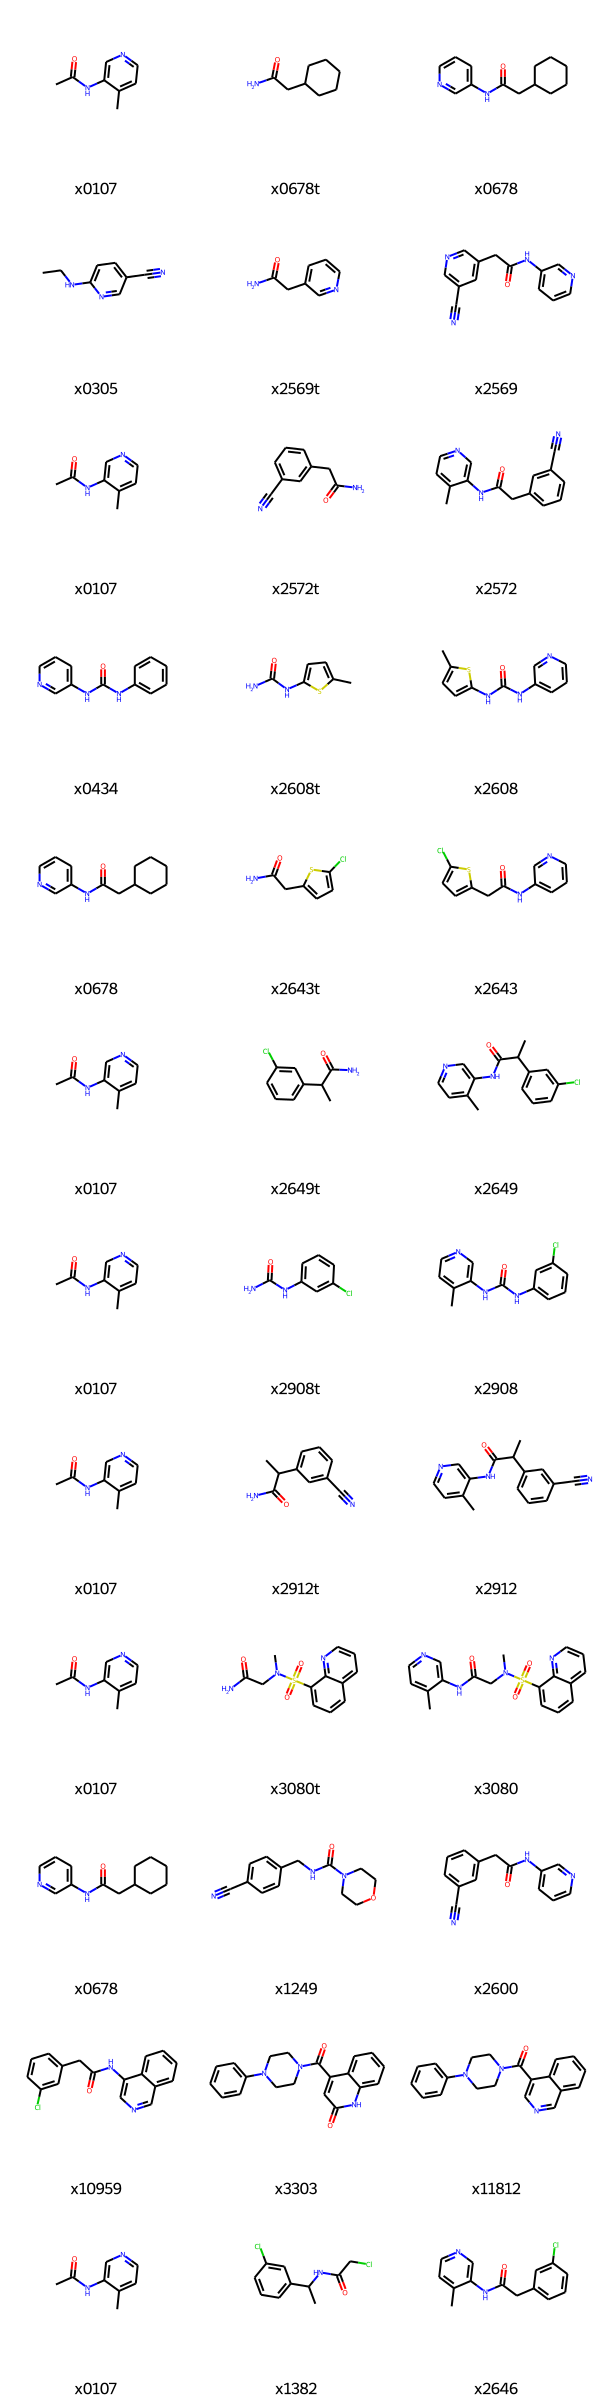

In [4]:
# visualise the test set molecules
all_mols = []
all_mol_ids = []

for fa, fb, mol, fa_id, fb_id, target_id in zip(fraga_mols, fragb_mols, target_mols, fraga_ids, fragb_ids, target_ids):
    all_mols.append(fa)
    all_mols.append(fb)
    all_mols.append(mol)
    all_mol_ids.append(fa_id)
    all_mol_ids.append(fb_id)
    all_mol_ids.append(target_id)

Draw.MolsToGridImage(all_mols, legends=all_mol_ids)  # 't' indicates where the fragment is a truncated version of the taret molecule

Use a function to check that the smiles of all the molecules exist in the network (as nodes)

In [5]:
check_for_nodes(fraga_smiles)
check_for_nodes(fragb_smiles)
check_for_nodes(target_smiles)

12 of 12 fragments present in network
12 of 12 fragments present in network
12 of 12 fragments present in network


## Synthon generation

Synthon expansion involves generating child synthons of one fragment (e.g. fragment B), and finding expansions of the other fragment (i.e. fragment A) that include that synthon (therefore identifying molecules that contain parts of each fragment). 

Generate all the synthons for each fragment A.

In [6]:
fraga_synthons = {}

for Id, fragment in zip(fraga_ids, fraga_smiles):
    print(f'Running fragment {Id}')
    fraga_synthons[Id] = get_synthons(fragment)

Running fragment x0107
Found 8 synthons
Running fragment x0305
Found 8 synthons
Running fragment x0107
Found 8 synthons
Running fragment x0434
Found 7 synthons
Running fragment x0678
Found 8 synthons
Running fragment x0107
Found 8 synthons
Running fragment x0107
Found 8 synthons
Running fragment x0107
Found 8 synthons
Running fragment x0107
Found 8 synthons
Running fragment x0678
Found 8 synthons
Running fragment x10959
Found 21 synthons
Running fragment x0107
Found 8 synthons


Generate all the synthons for each fragment B.

In [7]:
fragb_synthons = {}

for Id, fragment in zip(fragb_ids, fragb_smiles):
    print(f'Running fragment {Id}')
    fragb_synthons[Id] = get_synthons(fragment)

Running fragment x0678t
Found 2 synthons
Running fragment x2569t
Found 2 synthons
Running fragment x2572t
Found 7 synthons
Running fragment x2608t
Found 7 synthons
Running fragment x2643t
Found 7 synthons
Running fragment x2649t
Found 7 synthons
Running fragment x2908t
Found 7 synthons
Running fragment x2912t
Found 7 synthons
Running fragment x3080t
Found 2 synthons
Running fragment x1249
Found 21 synthons
Running fragment x3303
Found 29 synthons
Running fragment x1382
Found 7 synthons


## Expansions of fragment A

Fragment A is expanded using the synthons generated from the corresponding fragment B.

The results are stored in a nested dictionary of the following structure:

{identifier: {synthon: expansions}}

The identifier of the expansion consists of the ID of fragment A and ID of fragment B, joined by an underscore.

In [9]:
fraga_expansions = {}  # create empty dictionary

for fraga, fraga_id, fragb_id in zip(fraga_smiles, fraga_ids, fragb_ids):
    expand_id = fraga_id + '_' + fragb_id
    print(expand_id)
    fraga_expansions[expand_id] = get_expansions(fraga, fragb_synthons[fragb_id])  # use get_expansions function to generate expansions

x0107_x0678t
Synthon 0: found 112 expansions
Synthon 1: found 885 expansions
997 total expansions from 2 out of 2 synthons

x0305_x2569t
Synthon 0: found 15116 expansions
Synthon 1: found 5 expansions
15121 total expansions from 2 out of 2 synthons

x0107_x2572t
Synthon 0: found 2575 expansions
Synthon 1: found 0 expansions
Synthon 2: found 482 expansions
Synthon 3: found 0 expansions
Synthon 4: found 0 expansions
Synthon 5: found 500 expansions
Synthon 6: found 112 expansions
3669 total expansions from 4 out of 7 synthons

x0434_x2608t
Synthon 0: found 18126 expansions
Synthon 1: found 42 expansions
Synthon 2: found 0 expansions
Synthon 3: found 293 expansions
Synthon 4: found 0 expansions
Synthon 5: found 0 expansions
Synthon 6: found 134 expansions
18595 total expansions from 4 out of 7 synthons

x0678_x2643t
Synthon 0: found 0 expansions
Synthon 1: found 0 expansions
Synthon 2: found 0 expansions
Synthon 3: found 7 expansions
Synthon 4: found 144 expansions
Synthon 5: found 162 exp

The dictionary is saved to avoid re-running the query

In [10]:
# fraga_file_to_write = open("/home/sabsr3/xchem/fragment_network_merges/data/fraga_expansions.pickle", "wb")
# pickle.dump(fraga_expansions, fraga_file_to_write)

fraga_file_to_read = open("/home/sabsr3/xchem/fragment_network_merges/data/fraga_expansions.pickle", "rb")
fraga_expansions = pickle.load(fraga_file_to_read)

## Expansions of fragment B

Fragment B is expanded using the synthons generated from the corresponding fragment A.

In [11]:
fragb_expansions = {}  # create empty dictionary

for fragb, fragb_id, fraga_id in zip(fragb_smiles, fragb_ids, fraga_ids):
    expand_id = fragb_id + '_' + fraga_id
    print(expand_id)
    fragb_expansions[expand_id] = get_expansions(fragb, fraga_synthons[fraga_id])  # use get_expansions function to generate expansions

No data
Failed to read from defunct connection IPv4Address(('localhost', 7687)) (IPv4Address(('127.0.0.1', 7687)))
Transaction failed and will be retried in 0.9054178230277034s (Failed to write to closed connection IPv4Address(('localhost', 7687)) (IPv4Address(('127.0.0.1', 7687))))
x0678t_x0107
Synthon 0: found 554 expansions
Synthon 1: found 8157 expansions
Synthon 2: found 0 expansions
Synthon 3: found 1566 expansions
Synthon 4: found 1949 expansions
Synthon 5: found 86 expansions
Synthon 6: found 1 expansions
Synthon 7: found 46 expansions
12359 total expansions from 7 out of 8 synthons

x2569t_x0305
Synthon 0: found 16904 expansions
Synthon 1: found 17227 expansions
Synthon 2: found 1088 expansions
Synthon 3: found 0 expansions
Synthon 4: found 115 expansions
Synthon 5: found 668 expansions
Synthon 6: found 8168 expansions
Synthon 7: found 135 expansions
44305 total expansions from 7 out of 8 synthons

x2572t_x0107
Synthon 0: found 223 expansions
Synthon 1: found 3400 expansions
S

In [12]:
# fragb_file_to_write = open("/home/sabsr3/xchem/fragment_network_merges/data/fragb_expansions.pickle", "wb")
# pickle.dump(fragb_expansions, fragb_file_to_write)

fragb_file_to_read = open("/home/sabsr3/xchem/fragment_network_merges/data/fragb_expansions.pickle", "rb")
fragb_expansions = pickle.load(fragb_file_to_read)

## Analyse the expansions of fragment A

Perform some initial analysis of the expansions of fragment A, including calculating the similarity of the expansions to the 'target molecule' (i.e. the existing merge we are trying to find).

In [27]:
# 'un-nest' the dictionary
expansions = {}
for merge in fraga_expansions:
    mols = []
    for synthon in fraga_expansions[merge].values():
        for smiles in synthon:
            mols.append(smiles)
    expansions[merge] = mols

Print the number of total expansions for each test set merge

In [35]:
total = 0
for merge in expansions:
    print(len(expansions[merge]), 'expansions generated for', merge)
    total += len(expansions[merge])

print('')
print(total, 'expansions generated')

997 expansions generated for x0107_x0678t
15121 expansions generated for x0305_x2569t
3669 expansions generated for x0107_x2572t
18595 expansions generated for x0434_x2608t
817 expansions generated for x0678_x2643t
3752 expansions generated for x0107_x2649t
3752 expansions generated for x0107_x2908t
3558 expansions generated for x0107_x2912t
52 expansions generated for x0107_x3080t
3283 expansions generated for x0678_x1249
119 expansions generated for x10959_x3303
3751 expansions generated for x0107_x1382

57466 expansions generated


For each merge, check if the target molecule was found.

In [37]:
for Id, target, merge in zip(target_ids, target_smiles, expansions):
    if target in expansions[merge]:
        print(f'{Id} found in expansions')
    else:
        print(f'{Id} not found')

x0678 found in expansions
x2569 found in expansions
x2572 found in expansions
x2608 found in expansions
x2643 found in expansions
x2649 not found
x2908 not found
x2912 not found
x3080 found in expansions
x2600 found in expansions
x11812 not found
x2646 found in expansions


8 of 12 of the target molecules are found in the expansions

### Similarity analysis
Calculate the similarity of the expansions generated with the target molecule we are trying to find.

The function calc_tanimoto is used to do this. Morgan fingerprint (1024 bits) is used to do this.

In [38]:
def calc_tanimoto(target, results):
    """
    Calculate the tanimoto between the target molecule and all expansions.
    Return the results as a list.
    """
    target_fp = AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(target), 2, nBits=1024)
    tanimoto = []
    for m in results:
        fp = AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(m), 2, nBits=1024)
        tani = DataStructs.FingerprintSimilarity(target_fp, fp, metric=DataStructs.DiceSimilarity)
        tanimoto.append(tani)
    return tanimoto

In [39]:
# calculate tanimoto for all expansions of frag A
tanimotos = {}

for target, merge in zip(target_smiles, expansions):
    t = calc_tanimoto(target, expansions[merge])
    tanimotos[merge] = t

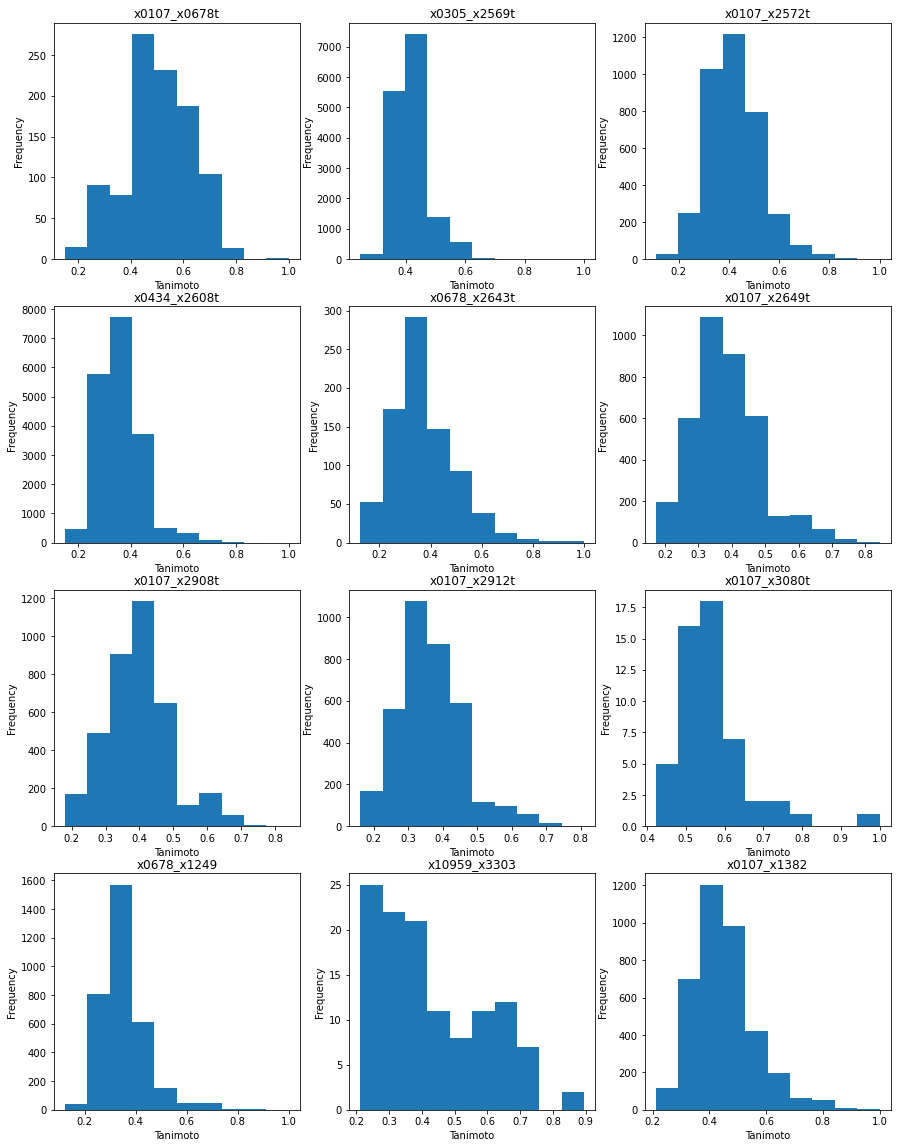

In [42]:
# plot tanimoto for each target
fig, axs = plt.subplots(4, 3, figsize=(15, 20))

for i, merge in enumerate(tanimotos):
    if i < 3:
        axs[0, i].hist(tanimotos[merge])
        axs[0, i].set_title(merge)
        axs[0, i].set(xlabel='Tanimoto', ylabel='Frequency')
    elif 2 < i < 6:
        axs[1, (i - 3)].hist(tanimotos[merge])
        axs[1, (i - 3)].set_title(merge)
        axs[1, (i - 3)].set(xlabel='Tanimoto', ylabel='Frequency')
    elif 5 < i < 9:
        axs[2, (i - 6)].hist(tanimotos[merge])
        axs[2, (i - 6)].set_title(merge)
        axs[2, (i - 6)].set(xlabel='Tanimoto', ylabel='Frequency')
    elif i > 8:
        axs[3, (i - 9)].hist(tanimotos[merge])
        axs[3, (i - 9)].set_title(merge)
        axs[3, (i - 9)].set(xlabel='Tanimoto', ylabel='Frequency')

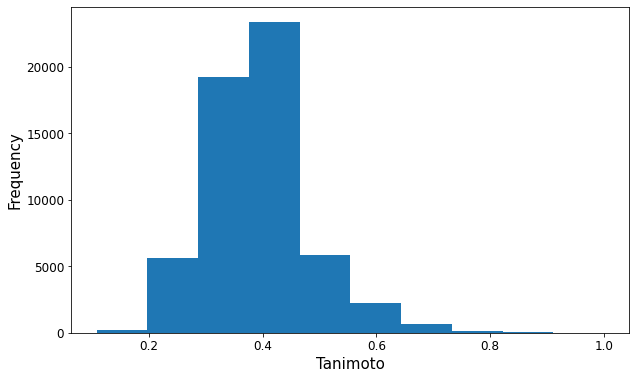

In [50]:
# plot histogram for all the expansions (across all targets)
all_tanimotos = []

for m in tanimotos:
    for t in tanimotos[m]:
        all_tanimotos.append(t)

plt.figure(figsize=(10,6))
plt.hist(all_tanimotos)
plt.xlabel('Tanimoto', fontsize=15)
plt.ylabel('Frequency', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

Calculate the proportions of the generated merges that are above a certain Tanimoto threshold with their corresponding target.

In [53]:
thresholds = [0.5, 0.6, 0.7, 0.8, 0.9]

for t in thresholds:
    count = 0
    for tan in all_tanimotos:
        if tan >= t:
            count += 1
    perc = round(count / len(all_tanimotos) * 100, 2)
    print(f"Percentage of compounds wit Tanimoto {t}: {perc}%")

print('')
print(f"Total number of compounds: {len(all_tanimotos)}")

Percentage of compounds above Tanimoto 0.5: 10.44%
Percentage of compounds above Tanimoto 0.6: 3.2%
Percentage of compounds above Tanimoto 0.7: 0.62%
Percentage of compounds above Tanimoto 0.8: 0.14%
Percentage of compounds above Tanimoto 0.9: 0.02%

Total number of compounds: 57466


Calculate tanimoto similarity between the merge and the fragments they were generated from

In [56]:
tanimotos_with_A = []

for merge, fragment in zip(expansions, fraga_smiles):
    t = calc_tanimoto(fragment, expansions[merge])
    for i in t:
        tanimotos_with_A.append(i)

In [58]:
tanimotos_with_B = []

for merge, fragment in zip(expansions, fragb_smiles):
    t = calc_tanimoto(fragment, expansions[merge])
    for i in t:
        tanimotos_with_B.append(i)

In [59]:
# give percentages for the number of compounds above a certain threshold across all targets
print('Similarity with fragment A')

for t in thresholds:
    count = 0
    for tani in tanimotos_with_A:
        if tani >= t:
            count += 1
    perc = round(count / len(tanimotos_with_A) * 100, 2)
    print(f"Percentage of compounds above Tanimoto {t}: {perc}%")

print('')
print('Similarity with fragment B')
for t in thresholds:
    count = 0
    for tani in tanimotos_with_B:
        if tani >= t:
            count += 1
    perc = round(count / len(tanimotos_with_B) * 100, 2)
    print(f"Percentage of compounds above Tanimoto {t}: {perc}%")

Similarity with fragment A
Percentage of compounds above Tanimoto 0.5: 10.31%
Percentage of compounds above Tanimoto 0.6: 4.14%
Percentage of compounds above Tanimoto 0.7: 0.61%
Percentage of compounds above Tanimoto 0.8: 0.01%
Percentage of compounds above Tanimoto 0.9: 0.0%

Similarity with fragment B
Percentage of compounds above Tanimoto 0.5: 6.79%
Percentage of compounds above Tanimoto 0.6: 1.01%
Percentage of compounds above Tanimoto 0.7: 0.03%
Percentage of compounds above Tanimoto 0.8: 0.0%
Percentage of compounds above Tanimoto 0.9: 0.0%


[Text(0.5, 0, 'Tanimoto'), Text(0, 0.5, 'Frequency')]

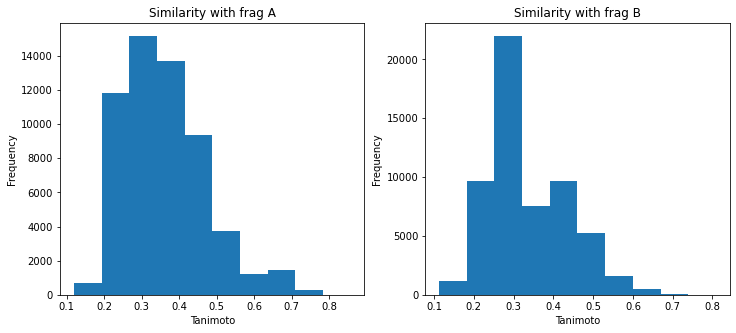

In [61]:
# plot tanimoto for each target
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].hist(tanimotos_with_A)
axs[0].set_title('Similarity with frag A')
axs[0].set(xlabel='Tanimoto', ylabel='Frequency')

axs[1].hist(tanimotos_with_B)
axs[1].set_title('Similarity with frag B')
axs[1].set(xlabel='Tanimoto', ylabel='Frequency')

## Visualise some of the results
First example is x0107_X0678t

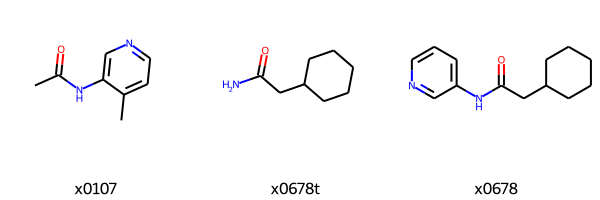

In [64]:
Draw.MolsToGridImage(all_mols[:3], legends=all_mol_ids[:3])

Draw some of the merges that were generated for these fragments. The legends show the Tanimoto with the target molecule.

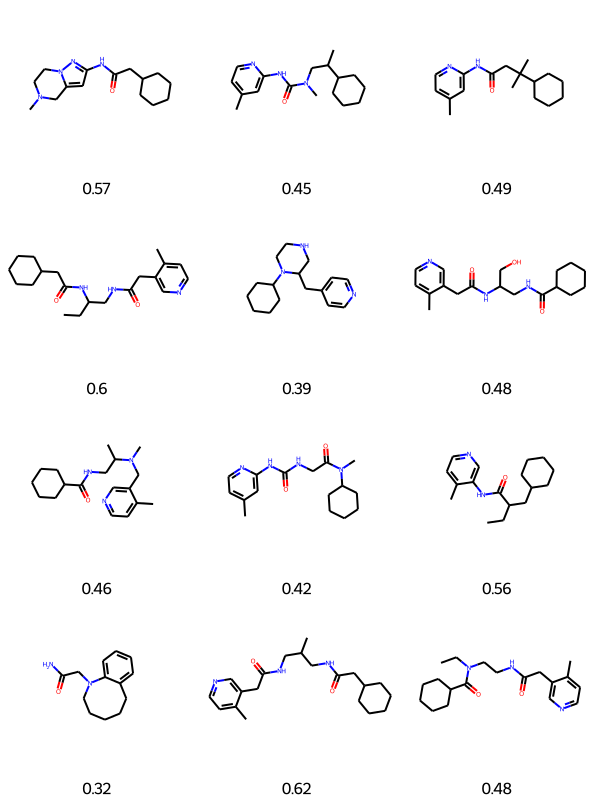

In [85]:
smiles_to_draw = random.choices(expansions['x0107_x0678t'], k=12)
mols_to_draw = mols_from_smiles(smiles_to_draw)
legends = [str(round(i, 2)) for i in (calc_tanimoto(target_smiles[0], smiles_to_draw))]

Draw.MolsToGridImage(mols_to_draw, legends=legends)